# Time Series Segmentation
In this notebook we are going to showcase a tool we have developed that segments a labeled time series.

The time series segmentation tool, learns its segmentation parameters from one or more initial, “golden truth” time series which is segmented on areas with different behaviors, and is able to segment a new input time series into areas with correspondingly different behaviors. Our task is to identify segments of a time series that correspond to aligned or misaligned areas. 
To identify them, we exploit the semantic segmentation algorithm of the MP suite, which segments a time series so that the number of
common motifs between different segments is minimized. Similarly, we extend this algorithm by defining a two-step scheme: at first, 
the optimal segmentation parameterization is identified on a “training” turbine, and then the segmentation model can be applied
on new turbines to identify areas with different behaviors with respect to misalignment angle.

In particular, we are given a labeled time series for training and at least one time series where we would like to apply our model. The task is to discover points which split the time series into areas with different behavior. In the current setting, we consider two classes/areas with different behavior: aligned and misaligned. We use time series data from wind turbines that are provided by [ENGIE](https://www.engie-deutschland.de/de). With the utilization of the data along with sparse labels that were available, for the yaw alignment or misalignment of a wind turbine. The notebook will focus on this specific dataset, however the methods are not restricted to wind turbines and can be easily used in other problems that can be formulated in a similar manner.

 


## Loaded libraries used

In [1]:
import re
import os, sys
from tqdm import tqdm
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.preprocessing import *
from modules.io import *
from modules.patterns import *
from modules.plots import *
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In the frame of this use case, we have been provided with a multidimensional time series measuring 
several variables (e.g. wind speed and direction, rotor rotation speed) including the active power of the turbine, for several turbines. 
Further, we have been provided labeled data for three of the turbines, regarding their measured yaw misalignment angle in specific time intervals. 

## Loading and preprocessing the dataset
We are loading the dataset and then perform some preprocessing steps. We are then able to filter out some variables (wind speed, rotor speed) of the dataset. This dataset provides regions where our turbine is working in optimal conditions. Afterwards we are going to change the granularity of the measurements from two seconds to thirty. 

In [2]:
df=load_df('/usr/local/share/data/more2020/post_treated_data/BEZ/BEBEZE01/BEBEZE01_scada_high_frequency.parquet')
df.index = pd.to_datetime(df.index)
#pick some specific columns
cols = ['wind speed', 'active power', 'rotor speed', 'wind direction', 'nacelle direction', 'pitch angle']
df = df[cols]
print(df.columns)

Index(['wind speed', 'active power', 'rotor speed', 'wind direction',
       'nacelle direction', 'pitch angle'],
      dtype='object')


In [3]:
df.head()

,wind speed,active power,rotor speed,wind direction,nacelle direction,pitch angle
datetime,,,,,,
2018-01-03 00:00:00,11.272275,1936.342041,15.220119,175.347885,180.116089,3.650000
2018-01-03 00:00:02,10.005727,1992.992554,15.229703,186.393020,180.116089,3.886307
2018-01-03 00:00:04,10.507183,2022.112915,15.239287,187.452170,180.116089,4.122613
2018-01-03 00:00:06,10.704224,2027.170776,15.248871,188.673038,180.116089,4.358920
2018-01-03 00:00:08,10.312802,2015.790172,15.258455,189.826151,180.116089,4.595226


In [4]:
# drop values of wind speed under 5m/s
df=filter_col(df, 0, less_than=5, bigger_than=None)
# drop values of rotor speed under 8rpm
df=filter_col(df, 2, less_than=8, bigger_than=None)
# Resample with 30second granularity
df=change_granularity(df,granularity='30s')

Filter Complete
Filter Complete
Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete


## Computing the multidimensional matrix profile
With the assistance of the [STUMPY](https://stumpy.readthedocs.io/en/latest/index.html) Python library, we are going to compute the multidimensional matrix profile (will be also denoted as MP) on our dataset. The algorithm supports constrained search, i.e. we can pick dimensions that are significant to be included. In our case, it is necessary to include power output (active power). After computing the MP we save it along with the index that accompanies it as a .npz file. 

For the purpose of demonstration we utilize the algorithm that creates a profile including a specific variable of interest. We create a matrix profile on a small subset of the input for demonstration purposes. This matrix profile will not be used later. Instead, we will load a precomputed matrix profile which is the result of the very same algorithm for the entire input set.


In [5]:
#motif_len #window size or length of the patterns we are looking for
#column  # The specific columns we want to build our profile
#path # to be saved path name

# pick the dimensions that must be included in the multidimensional mp 
df1=df[:200]
df1=df1[cols]
include = ['active power']
col_indexes = []
for n in include:
    col_indexes.append(df1.columns.get_loc(n))

mp1,mpi1= create_mp(df=df1,motif_len=15,column=[0,1,2,3,4,5],path= "./test", include=col_indexes, dask=True)
mp1,mpi1

/home/panpan/MoreVm/lib/python3.6/site-packages/stumpy/core.py:443: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(welford_nanvar(a, w))


Multivariate with Dask


(array([[2.97799411, 3.03651992, 3.06990377, ..., 2.35119162, 2.18162331,
         2.13854328],
        [1.48899705, 1.51825996, 1.53495188, ..., 1.65399092, 1.91882404,
         1.82104453],
        [2.39028717, 2.28425717, 2.13203285, ..., 2.1118304 , 2.30101805,
         2.30892035],
        [2.65269899, 2.84304428, 2.90487452, ..., 2.14769568, 2.31358436,
         2.38087263],
        [3.1729178 , 3.10629723, 3.26224124, ..., 2.64279927, 2.81715602,
         2.84317303],
        [3.63717448, 3.67892053, 3.60404236, ..., 3.11729082, 3.33847046,
         3.24956121]]),
 array([[139, 164, 165, ..., 108, 109, 110],
        [139, 164, 165, ..., 128,  82, 130],
        [139, 127, 128, ..., 131, 132, 133],
        [ 91, 143, 128, ..., 131, 132, 133],
        [ 91, 143, 144, ..., 131, 132, 133],
        [ 91, 143,  62, ..., 131, 132, 133]]))

We load a precomputed multidimensional matrix profile with exactly the same configuration as above. This profile consists of 30 minute patterns length for our wind turbines time series. A pattern is a region (a subsequence) of time series that has a specific structure. In this line we load all the three turbines which the other two will be used later in our notebook.


In [6]:
granularity = '30s'
motif_len=60

cols = ['wind speed', 'active power', 'rotor speed', 'wind direction', 'nacelle direction', 'pitch angle']
sstr = "".join([w[0].upper() for attr in cols for w in re.split('[\s_]', attr + '_.')])
files = ['BEBEZE01', 'BEBEZE02', 'BEBEZE03'] # Three turbines that belong in the same farm
mp = {}
mpi = {}
for file_name in files:
    loaded = np.load(f'matrix-profiles/mp_multivariate_filtered_{file_name}_{granularity}{motif_len}_{sstr.replace(".", "_")[:-1]}.npz', allow_pickle=True)
    mp[file_name] = loaded['mp']
    mpi[file_name] = loaded['mpi']

We illustrate a graph of our timeseries (BEBEZE01) for a specific variable (active power). Here we present a graph of the multidimensional matrix profile (second graph). We denote with black arrow the Top-1 motif in our dataset.

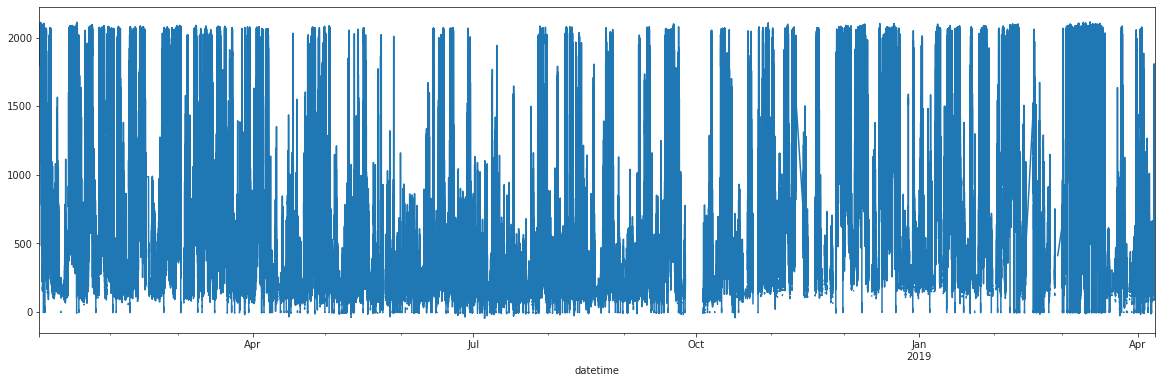

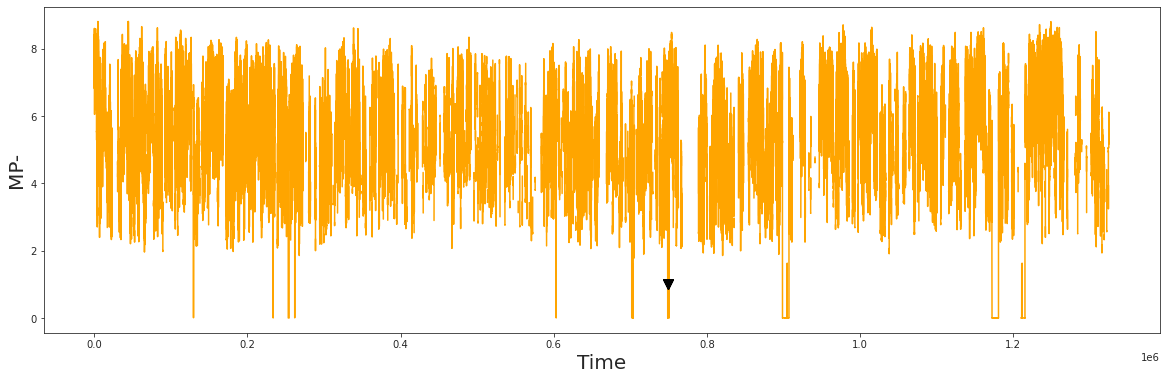

In [7]:
plot_profile(df=df,mp=mp['BEBEZE01'][5],col_name='active power')

# Semantic Segmentation of the Time series

When dealing with a multidimensional MP one must pick the k most relevant dimensions, as the addition of extra irrelevant dimensions can degrade the performance of the algorithm significantly. That problem as well as a way to combat it, is described in the paper [Matrix Profile VI: Meaningful Multidimensional Motif Discovery](https://www.researchgate.net/publication/322001553_Matrix_Profile_VI_Meaningful_Multidimensional_Motif_Discovery). The proposed way to tackle this problem is to make use of the "knee" or "elbow" method, whick is widely used in clustering. According to this method, we plot the minimum value of the MP for each value k of dimensions and find the "turning point". By doing this in our data (as seen in the cell below), we observe that after the value k = 4 the values start to dramatically increase suggesting that the "natural" dimensionality of patterns in our data is for k = 4 number of dimensions. (Since k is 0-indexed this means 5 dimensions)

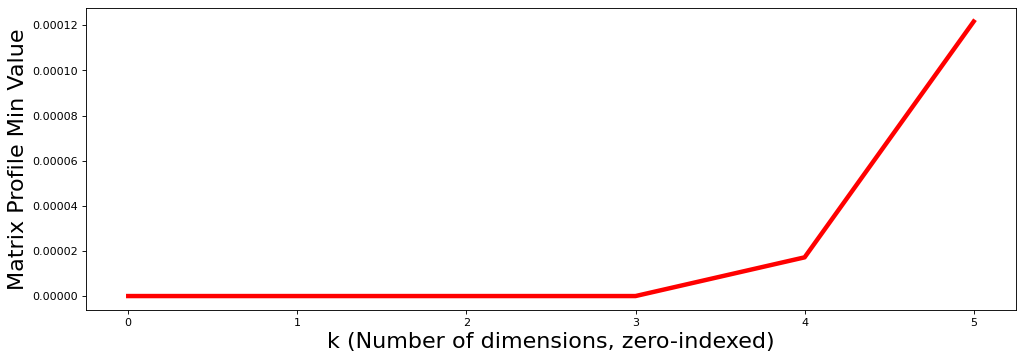

In [8]:
plot_knee(mp['BEBEZE01'])

In this step we will identify the segments we want to divide our time series. We search for 5 changepoints so as to partition the time series into 6 regions. Those points indicate abrupt changes in the time series. Our goal ideally would be to align the change points (blue lines) with the labels (green lines). This would mean that we found patterns that make sense in a more specific way. More specificaly the calculation of those points comes with respect to a computed multidimensional matrix profile. This procedure is available through the [Fluss Algorithm](https://stumpy.readthedocs.io/en/latest/_modules/stumpy/floss.html#fluss) which performs semantic segmentation on a time series, into a learning scheme that is able to learn an appropriate configuration of the algorithm for the specific task. This way, the algorithms can learn on the behavior of a turbine and be able to segment new turbines into aligned/misaligned areas. We input a list of integers 'L'. Essentialy each 'L' is a subsequence of the index. Each integer excludes the algorithm of detecting points to the edges of the time series. The 'L' sets the Corrected Arc Curve (i.e. the plot that we will see in the next lines) with one depending on the length of L multiplied with an exclusion factor (excl_factor). The Corrected Arc Curve resolves the issue of ignoring the effects of off-plot trees on variables measured within a plot boundary (edge bias) of Arc Curve. The Arc Curve is essentially a time series containing non negative integers, where each integer corresponds to a point in the original time series and specifies how many nearest neighbor arcs (arcs connecting the two members of a motif) cross this point. Our goal is that they exist the least neighbors between those regions. The number of dimensions used throughout this procedure is given from the abovementioned elbow method. So in the end we will receive locations (indexes) of the changepoints. This procedure is described in [Matrix Profile VIII: Domain Agnostic Online Semantic Segmentation at Superhuman Performance Levels](https://www.cs.ucr.edu/~eamonn/Segmentation_ICDM.pdf).

In [9]:
# # We set different exclusion subsequences lengths in order to create more models and select later
L= np.arange(18000,40000, 1000).astype(int)
output=segment_ts(mpi['BEBEZE01'],k_optimal=5,path=None,L=L,regions=6,excl_factor=5)

100%|██████████| 22/22 [29:05<00:00, 79.34s/it]


Plotting and scoring. for each member of 'L' we compute a score (top of the graph). This score is a distance (dynamic time warping distance) with the fixed dates (labels) and the segments that are under inspection. This distance serves as a measure of cost or penalty for our model, providing an estimate of how far it is from making predictions as expected. We plot all but we keep/save(up to 5 in the specific example) the minimum distances.

/home/panpan/MoreVm/morets/notebooks/panpan/modules/plots.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0.1}, figsize=(20, 3))


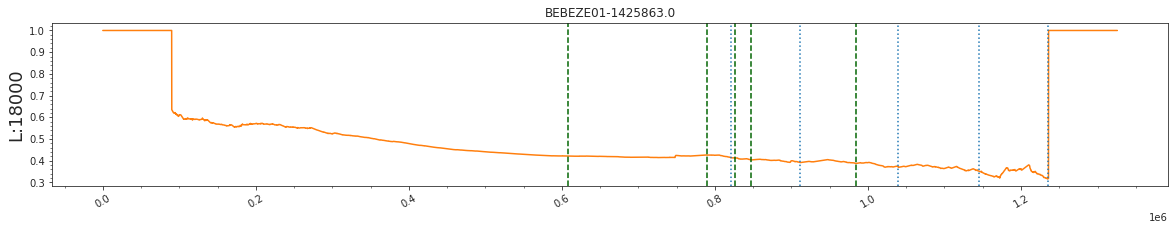

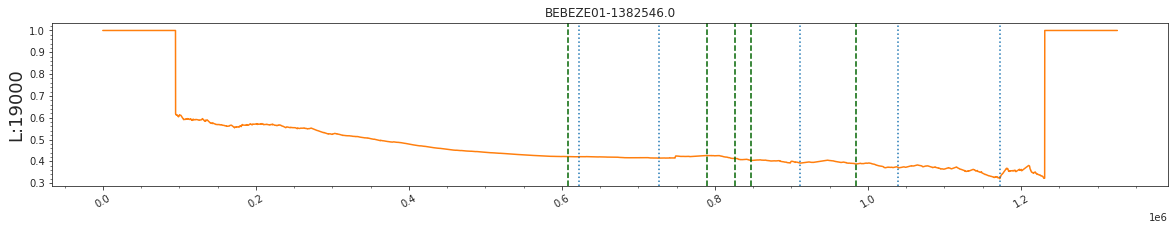

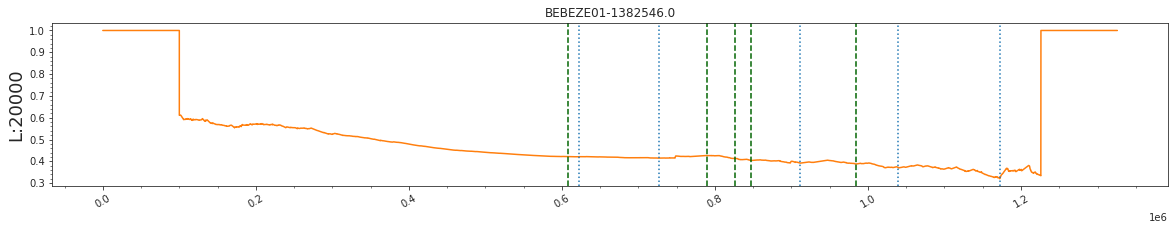

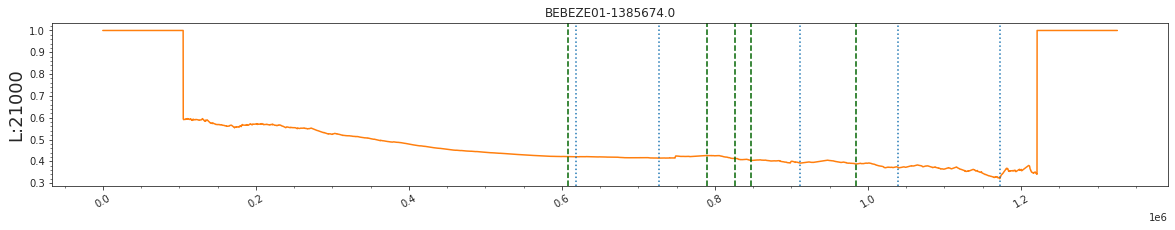

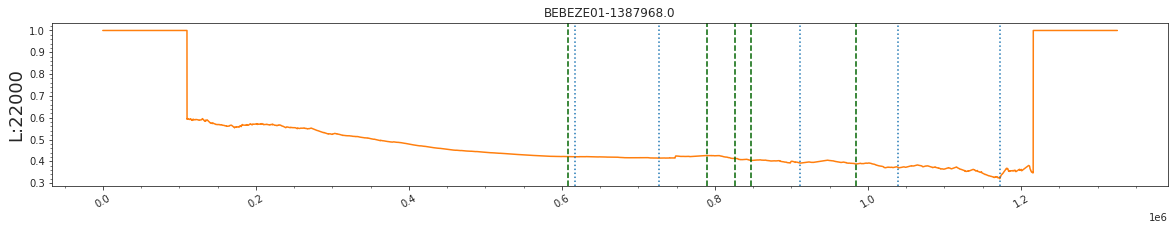

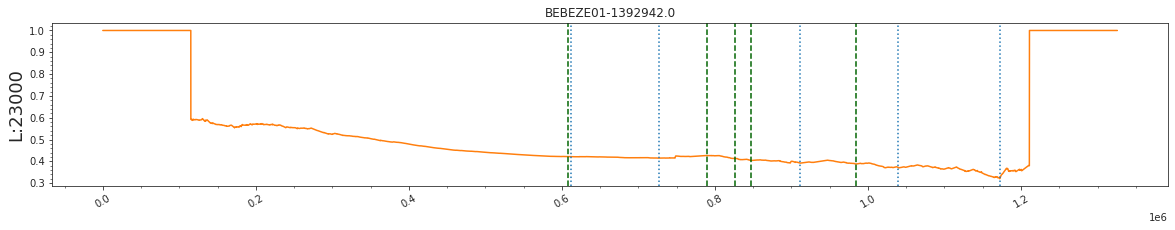

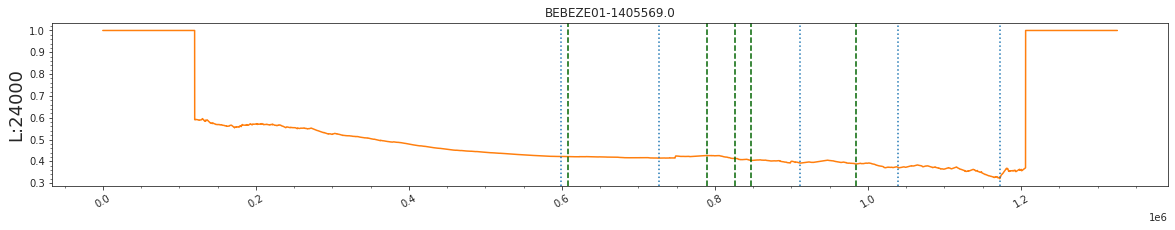

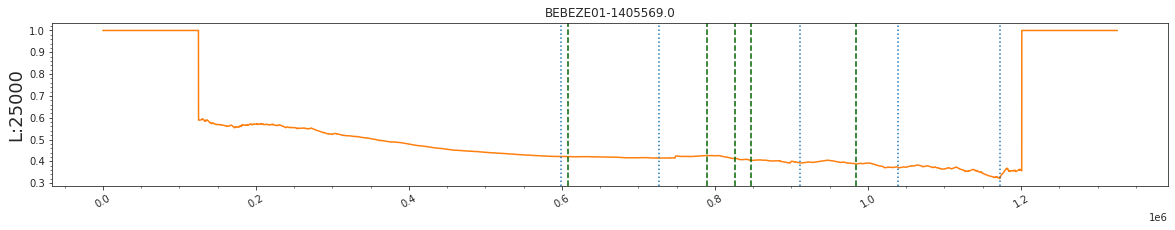

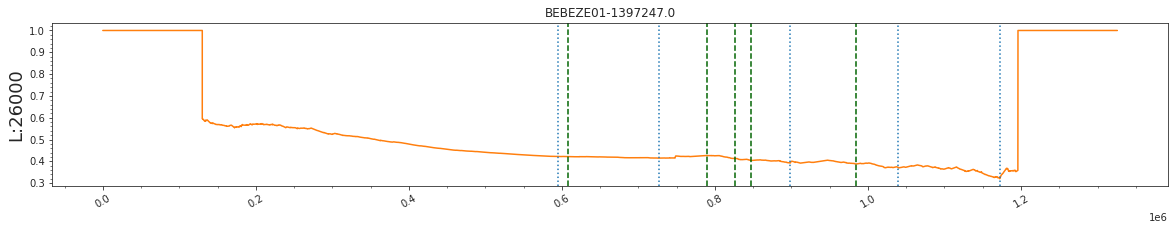

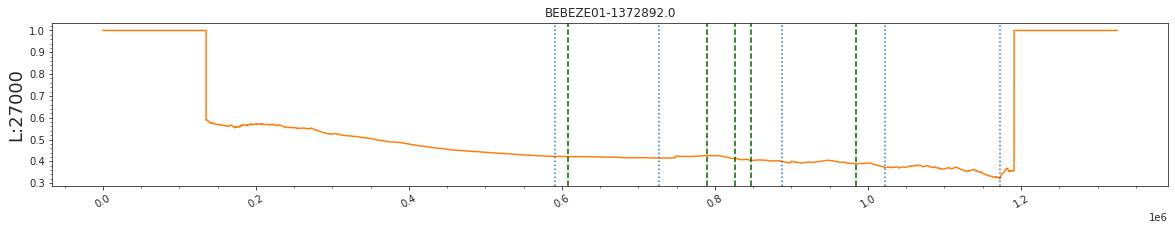

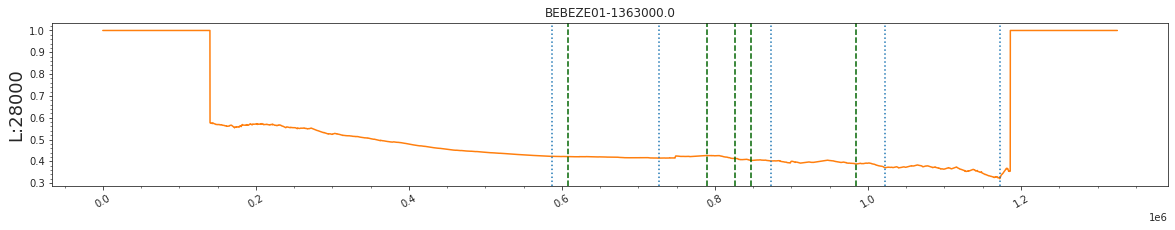

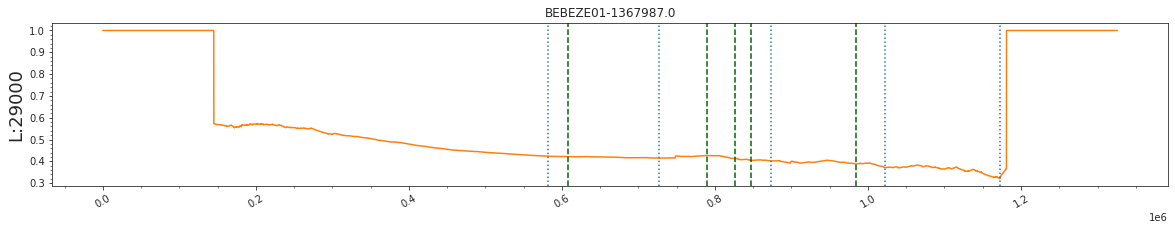

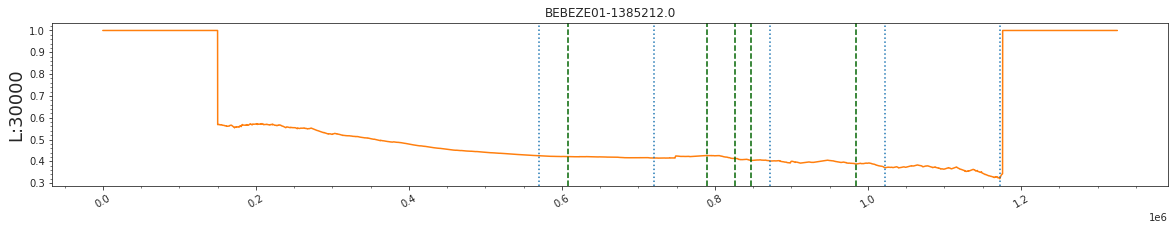

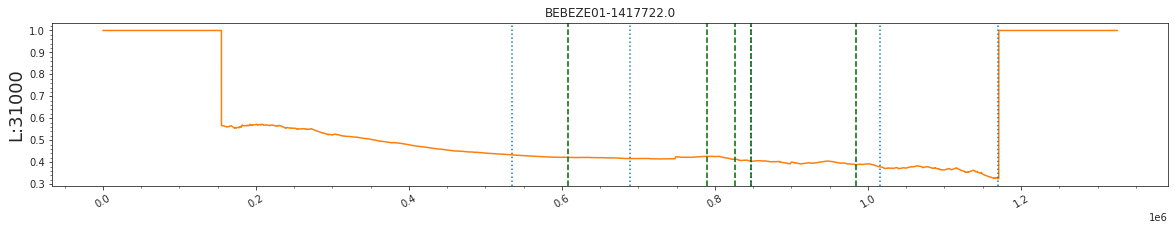

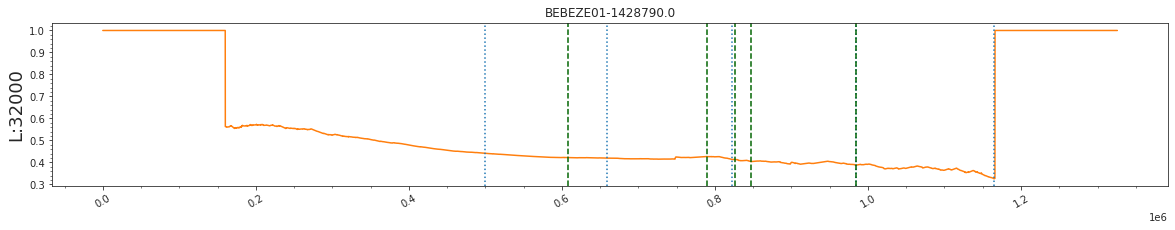

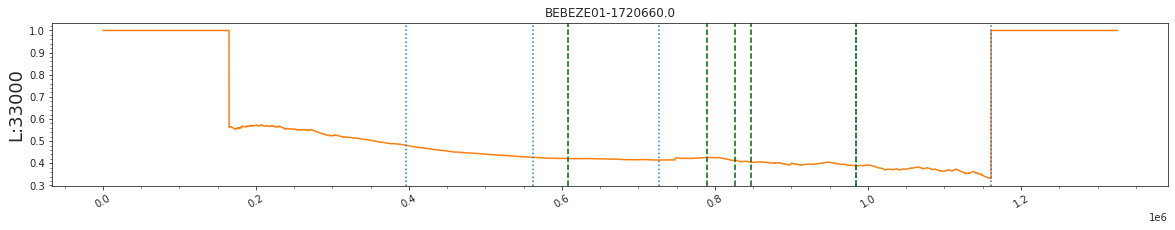

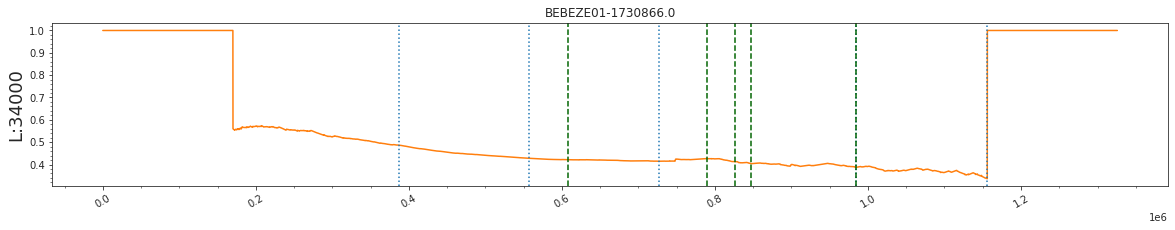

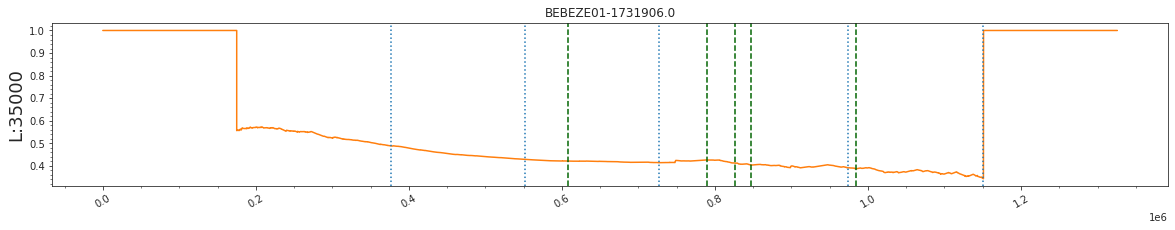

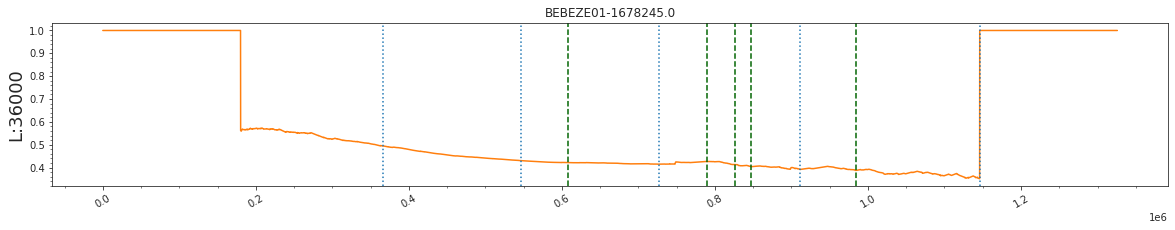

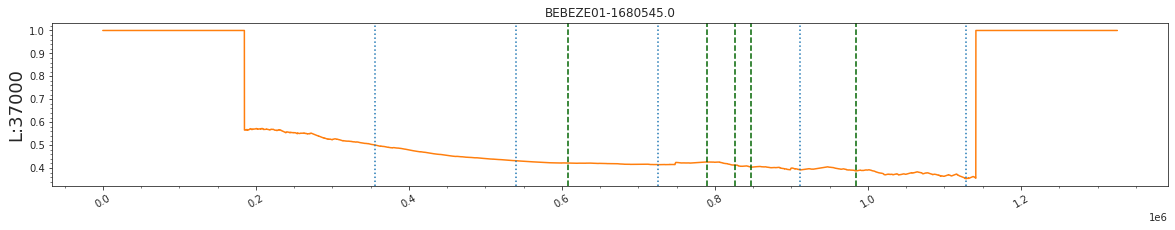

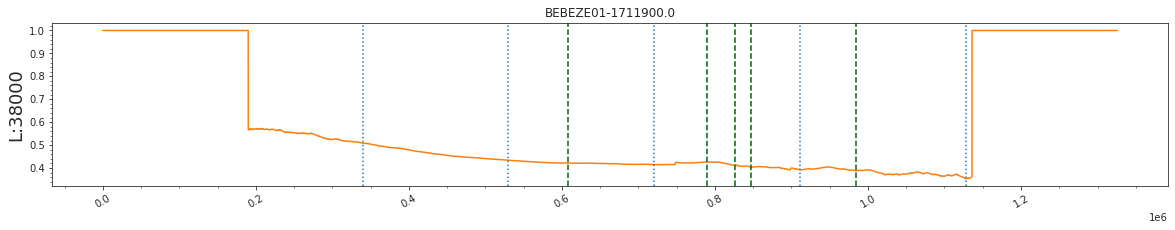

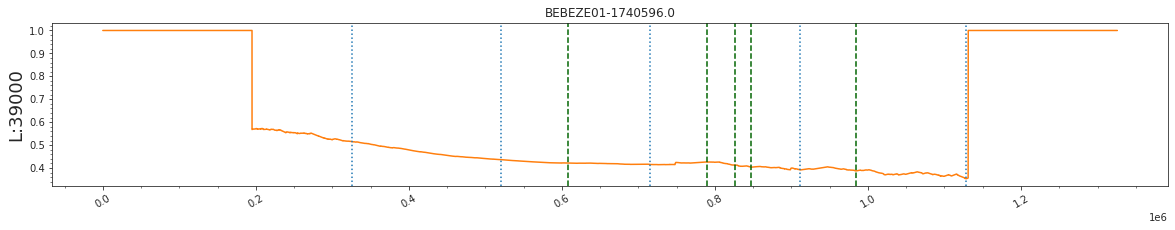

In [10]:
# The provided Labels which segment areas to alligned and misalligend
fixed_dates = [
    '2018-08-02 00:00:00',
    '2018-10-04 00:00:00',
    '2018-10-17 00:00:00',
    '2018-10-24 00:00:00',
    '2018-12-11 00:00:00',
]
best,model =plot_segmentation(df=df, path=None, output=output[0], fixed_dates=fixed_dates, file_name= "BEBEZE01", top_seg=5) 

In [11]:
model

,L,Changepoints indexes,Changepoints Dates,Normalized Distance
0,18000,"[1235560, 1145559, 1039863, 911129, 821128]","[2019-03-08, 2019-02-04, 2018-12-30, 2018-11-15, 2018-10-15]",0.166482
1,19000,"[1172161, 1039863, 911129, 726766, 622161]","[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-12, 2018-08-07]",0.051764
2,20000,"[1172161, 1039863, 911129, 726766, 622161]","[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-12, 2018-08-07]",0.051764
3,21000,"[1172161, 1039863, 911129, 726766, 619033]","[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-12, 2018-08-05]",0.060048
4,22000,"[1172161, 1039863, 911129, 726766, 616739]","[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-12, 2018-08-05]",0.066124
5,23000,"[1172161, 1039863, 911129, 726766, 611765]","[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-12, 2018-08-03]",0.079296
6,24000,"[1172161, 1039863, 911129, 726766, 599138]","[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-12, 2018-07-30]",0.112737
7,25000,"[1172161, 1039863, 911129, 726766, 599138]","[2019-02-14, 2018-12-30, 2018-11-15, 2018-09-12, 2018-07-30]",0.112737
8,26000,"[1172161, 1039863, 898559, 726766, 594890]","[2019-02-14, 2018-12-30, 2018-11-10, 2018-09-12, 2018-07-28]",0.090697
9,27000,"[1172161, 1022337, 887336, 726766, 590496]","[2019-02-14, 2018-12-23, 2018-11-07, 2018-09-12, 2018-07-27]",0.026197


## Testing of the tool on similar time series 
In the next cells, we repeat the previous preprocessing procedure on two other similar time series (same farm) and test the segmentation algorithm on those series by employing the same methodology.

In [12]:
cols = ['wind speed', 'active power', 'rotor speed', 'wind direction', 'nacelle direction', 'pitch angle']
#preprocessing at BEBEZE02
df2=load_df('/usr/local/share/data/more2020/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet')
df2.index = pd.to_datetime(df2.index)
df2 = df2[cols]
df2=filter_col(df2, 0, less_than=5, bigger_than=None)
df2=filter_col(df2, 2, less_than=8, bigger_than=None)
df2=change_granularity(df2, granularity='30s')
#mp2,mpi2= create_mp(df=df2,motif_len=60,columns=df2.columns,path="./test",dask=False)

#preprocessing at BEBEZE03
df3=load_df('/usr/local/share/data/more2020/post_treated_data/BEZ/BEBEZE03_scada_high_frequency.parquet')
df3.index = pd.to_datetime(df3.index)
df3 = df3[cols]
df3=filter_col(df3, 0, less_than=5, bigger_than=None)
df3=filter_col(df3, 2, less_than=8, bigger_than=None)
df3=change_granularity(df3, granularity='30s')
#mp3,mpi3= create_mp(df=df3,motif_len=60,columns=df3.columns,path="./test",dask=False)

Filter Complete
Filter Complete
Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
Filter Complete
Filter Complete
Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete


We deploy and validate our model on the other two similar datasets.

In [13]:
L=[]
for segmentation in best:
    L.append(segmentation['L'])
L.sort()
#Calculation of the points where segments taking place in the other two turbines
output1=segment_ts(mpi['BEBEZE01'], k_optimal=5, path=None, L=L, regions=6, excl_factor=5)
output2=segment_ts(mpi['BEBEZE02'], k_optimal=5, path=None, L=L, regions=6, excl_factor=5)
output3=segment_ts(mpi['BEBEZE03'], k_optimal=5, path=None, L=L, regions=6, excl_factor=5)

100%|██████████| 5/5 [07:09<00:00, 86.00s/it]


We apply the selected models to the new time series. 
We observe that the results share a similar behavior as we can see from the graphs below. This signifies that our algorithm computed an elegant segmentation of the time series.

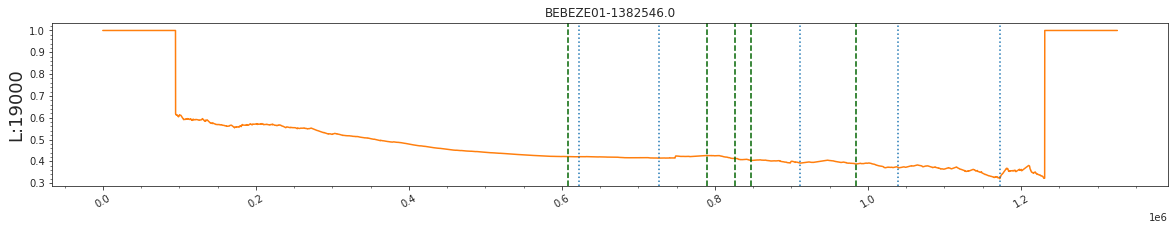

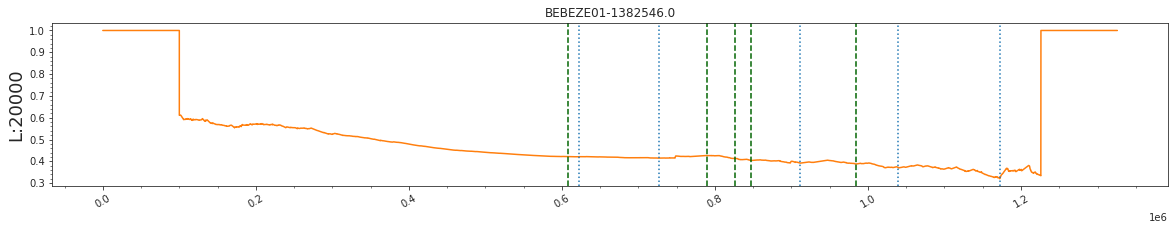

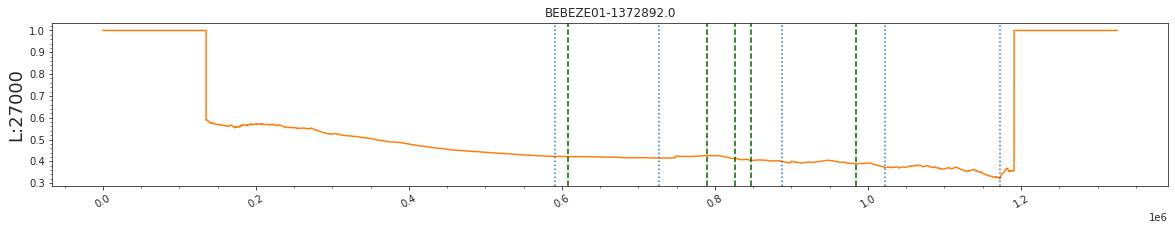

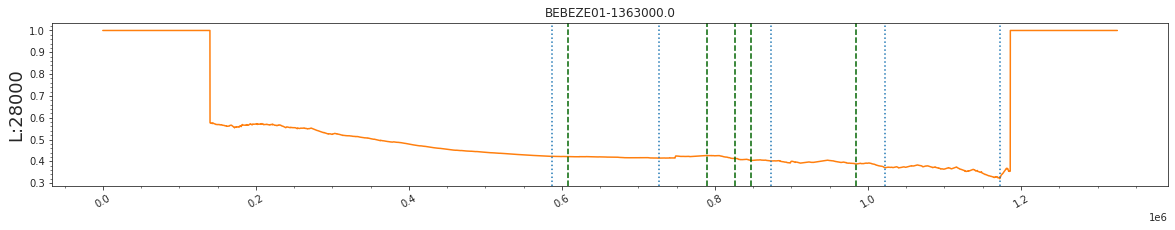

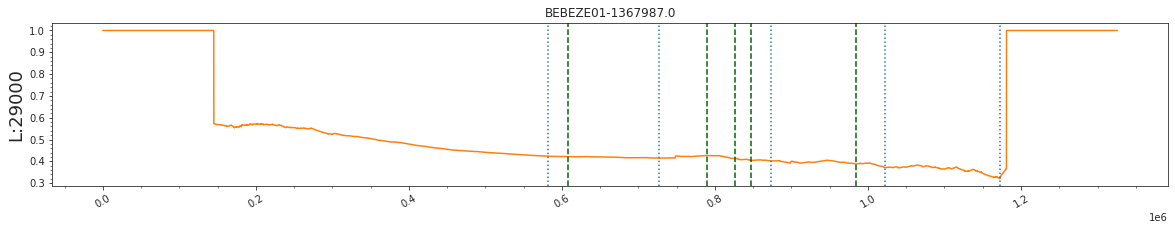

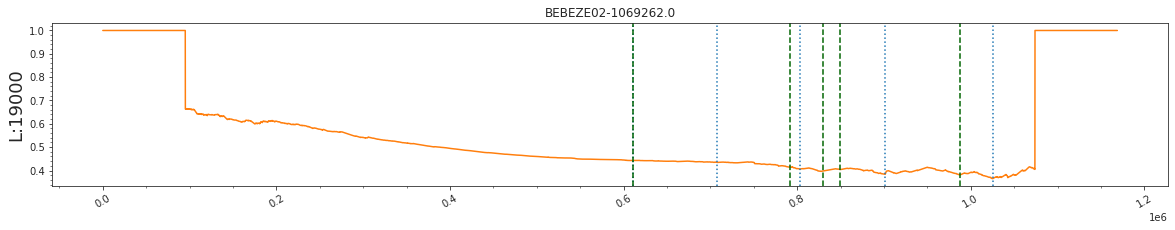

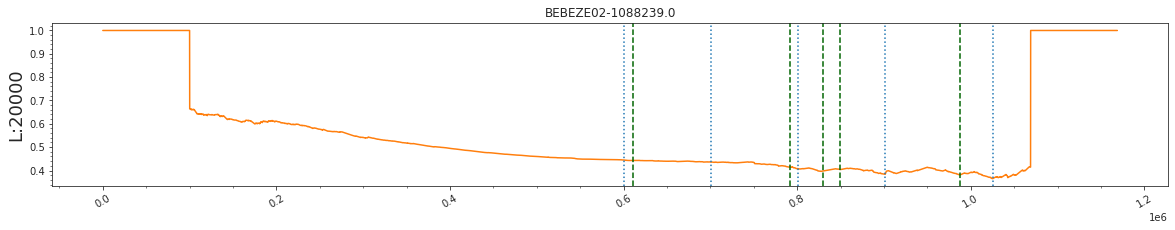

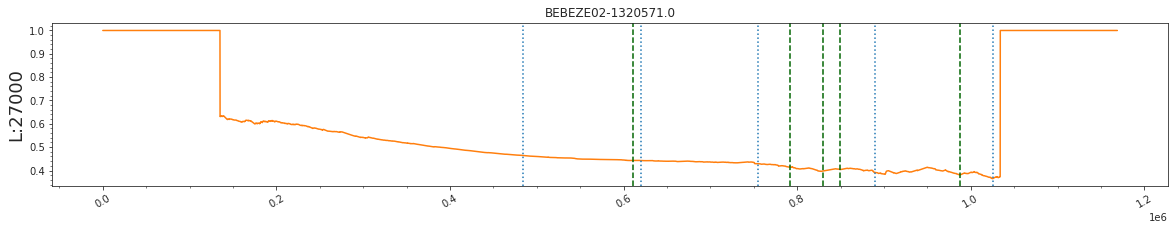

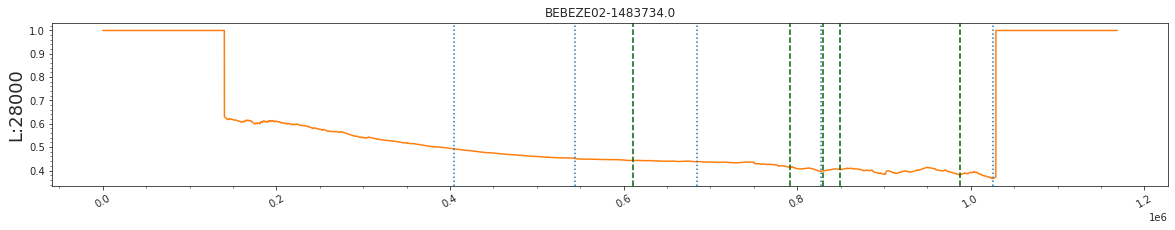

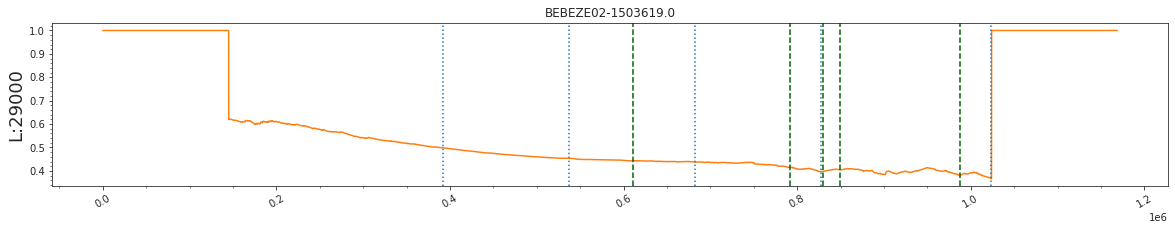

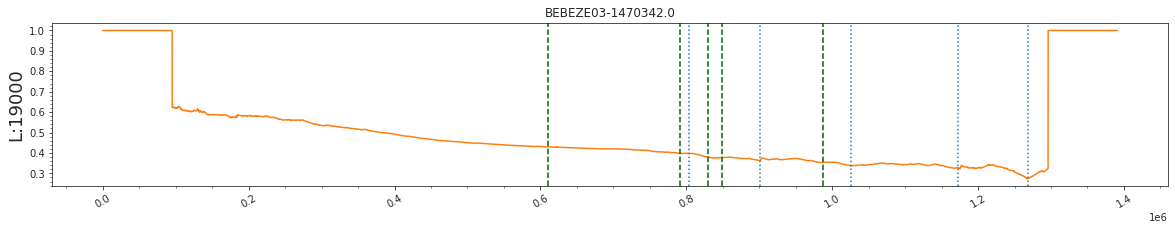

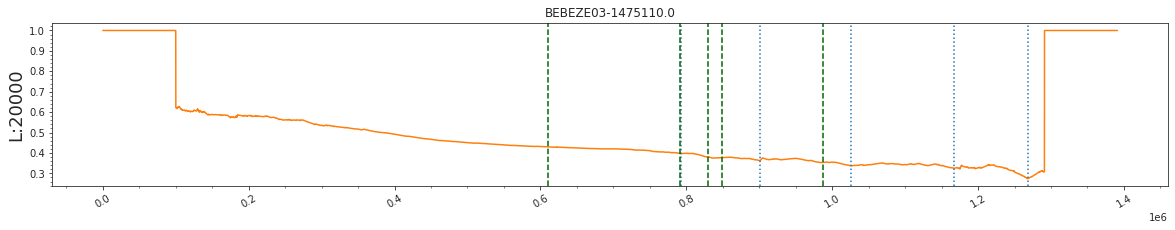

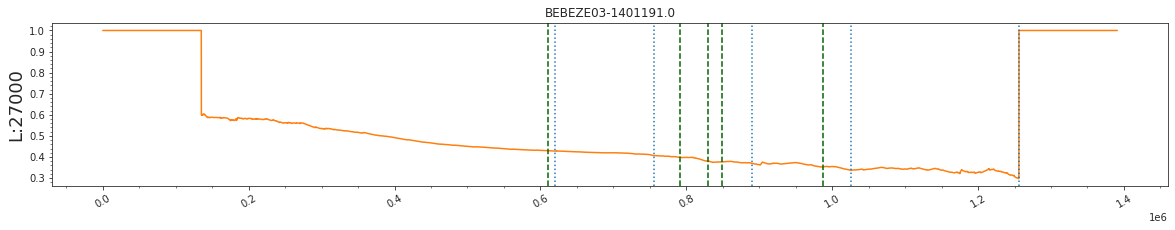

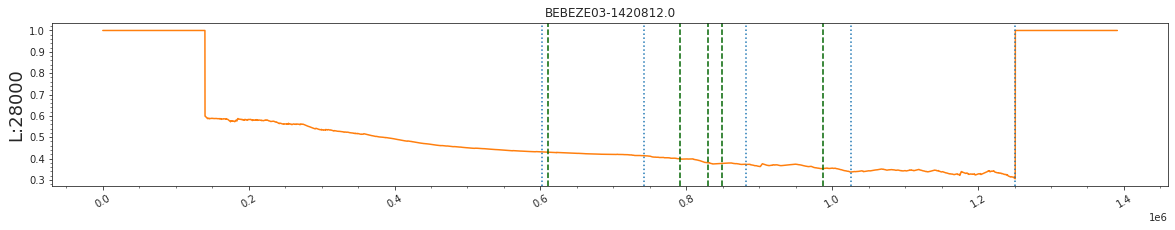

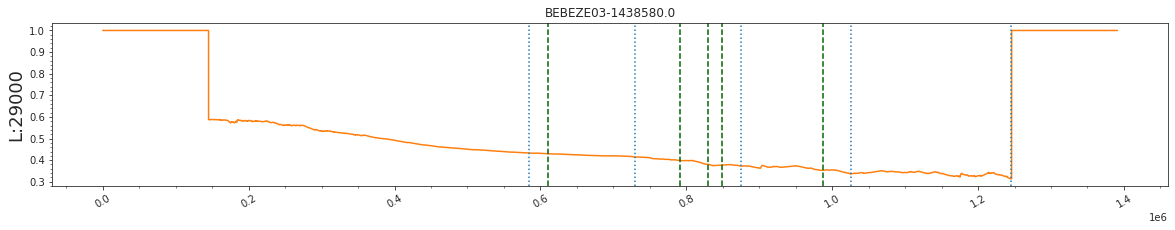

In [14]:
best1,model1 =plot_segmentation(df, path=None, output=output1[0], fixed_dates=fixed_dates, file_name= "BEBEZE01", top_seg=5) 
best2,model2=plot_segmentation(df2, path=None, output=output2[0], fixed_dates=fixed_dates, file_name= "BEBEZE02", top_seg=5)
best3,model3=plot_segmentation(df3, path=None, output=output3[0], fixed_dates=fixed_dates, file_name= "BEBEZE03", top_seg=5)